In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from scipy.stats import chi2_contingency
from fuzzywuzzy import process
from rapidfuzz import process, fuzz
import re




In [250]:
df = pd.read_csv('bases/PAC_cleaned.csv')

In [251]:
labels = ['1-50', '51-200', '201-500', '501-1000', '1001-5000', '5001-10000', '10001+']


def exploratory_report(df, target_column, target_value, explained_column):

    list_of_x = []
    list_of_y_abs = []
    list_of_y_proportion = []
   
    new_df = df[[target_column, explained_column]].copy()
        
    # Store the new DataFrame in a dictionary with a dynamic name
    df_total = f'{df}{explained_column}'
    data_frames_dict = {df_total: new_df}

    # Calculate the mean proportion of the target value
    total_count = data_frames_dict[df_total].shape[0]

    target_count = data_frames_dict[df_total][data_frames_dict[df_total][target_column] == target_value].shape[0]

    mean_proportion = target_count / total_count * 100


    print(data_frames_dict[df_total].shape)
    data_frames_dict[df_total].head()

    for value in data_frames_dict[df_total][explained_column].unique():
        
        new_df = data_frames_dict[df_total][data_frames_dict[df_total][explained_column] == value]
        data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'] = new_df


    print('Total:', data_frames_dict[df_total].shape[0])

    for value in data_frames_dict[df_total][explained_column].unique():

        print(f"{value}: {data_frames_dict[df_total][data_frames_dict[df_total][explained_column] == value].shape[0]}")

    for value in data_frames_dict[df_total][explained_column].unique():

        new_df = data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'][data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'][target_column] == target_value]
        data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'] = new_df

    for value in data_frames_dict[df_total][explained_column].unique():
        
        print(f"{value}  {target_value}: {data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'].shape[0]}")
        print(f"{value}  Total%: {data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'].shape[0]}")
        print(f'Percentualmente: {100 * data_frames_dict[f"{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}"].shape[0] / data_frames_dict[f"{data_frames_dict[df_total]}_vs_{value}"].shape[0]:.2f}%', end='\n\n')

        list_of_x.append(f'{value} vs {target_value}')
        list_of_y_abs.append(data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'].shape[0])
        list_of_y_proportion.append(round(100 * data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'].shape[0] / data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'].shape[0], 2))



    if explained_column != "Mês" and explained_column != "Dia da Semana" and explained_column != "Setor" and explained_column !="Raio" and explained_column != "HorasCorte" and explained_column != "employee_category":
        # Zip the lists and sort based on list_of_y_abs
        sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: x[0], reverse=False)

        # Unzip the sorted data
        sorted_x, sorted_y_abs, sorted_y_proportion = zip(*sorted_data)

        sorted_x = tuple(x.split(' vs ')[0] for x in sorted_x)

        mean_abs = np.mean(sorted_y_abs)
        
        # mean_proportion = np.mean(sorted_y_proportion)

        custom_palette = select_colors(len(sorted_x))

        plt.figure(figsize=(10, 5))

        # Create bar plot for absolute values with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_abs, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_abs, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Aparições')
        # plt.title(f'Problemas de {target_value.lower()} por {explained_column.lower()}')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.0f}'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.show()

        plt.figure(figsize=(10, 5))

        # Create bar plot for proportions with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_proportion, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_proportion, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Proporção')
        # plt.title(f'Problemas {target_value.lower()} por {explained_column.lower()} (Percentualmente)')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol
        plt.show()
        
    else:

        if explained_column == "Mês":
            # Sorting by months by zipping
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: Mês.index(x[0].split(' vs ')[0]), reverse=False)
        if explained_column == "Dia da Semana":
            # Sorting by days of the week by zipping
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: DiadaSemana.index(x[0].split(' vs ')[0]), reverse=False)
            
        if explained_column == "Raio":
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: Raio.index(x[0].split(' vs ')[0]), reverse=False)

        if explained_column == "HorasCorte":
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: Horarios.index(x[0].split(' vs ')[0]), reverse=False)

        if explained_column == "employee_category":
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: labels.index(x[0].split(' vs ')[0]), reverse=False)
        # Unzip the sorted data
        sorted_x, sorted_y_abs, sorted_y_proportion = zip(*sorted_data)
        
        sorted_x = tuple(x.split(' vs ')[0] for x in sorted_x)
        # Create bar plot for absolute values with sorted data

        mean_abs = np.mean(sorted_y_abs)

        # mean_proportion = np.mean(sorted_y_proportion)


        custom_palette = select_colors(len(sorted_x))

        plt.figure(figsize=(10, 5))

        # Create bar plot for absolute values with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_abs, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_abs, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Aparições')
        # plt.title(f'Problemas de {target_value.lower()} por {explained_column.lower()}')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.0f}'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.show()

        plt.figure(figsize=(10, 5))

        # Create bar plot for proportions with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_proportion, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_proportion, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Proporção')
        # plt.title(f'Problemas {target_value.lower()} por {explained_column.lower()} (Percentualmente)')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol
        plt.show()


In [252]:
bluey = [
    '#001834',
    '#002147',
    '#002a5b',
    '#00336f',
    '#003c82',
    '#004596',
    '#004ea9',
    '#0057bd',
    '#0060d1',
    '#0069e4',
    '#0072f8','#0D7CFF', '#2087FF', '#3492FF', '#479CFF', '#5BA7FF', '#6FB1FF', '#82BCFF', '#96C6FF', '#A9D1FF', '#BDDCFF', '#D1E6FF', '#E4F1FF', '#F8FBFF']


orangey = [
    "#77410E",
    "#8E4E11",
    "#A55A13",
    "#BD6715",
    "#D47317",
    "#E7801E",
    "#EA8D34",
    "#ED9A4B",
    "#F0A762",
    "#F2B479"
]

orangey_reversed = [
    "#F2B479",   
    "#E7801E",
]


bluey_short = [
    '#A9D1FF',
    '#D1E6FF'
]
# Neutral point
neutral = ['#FFFFFF']

# Combined diverging palette
diverging_palette = bluey_short + orangey_reversed    

def select_colors(num_columns):
    if num_columns >= len(bluey):
        return bluey
    
    step = len(bluey) // num_columns
    selected_colors = bluey[:num_columns * step:step]
    return selected_colors

In [253]:
# Write a regex expression to capture the date bewteen the parenthesis in "Semana"


In [254]:
# Convert the "Semana" column to datetime

df['Semana'] = pd.to_datetime(df['Semana'])

In [255]:
# Only keep the Analytics "Portfólio" rows

df = df[df['Portfólio'] == 'Analytics']



In [256]:
df

,Semana,Empresa,Setor do LinkedIn,Número de Funcionários,Nome,Cargo,Email,Prospecção,STATUS,Hunter,Portfólio,Valor,ITIP
172,2023-01-09,Infleet - Gestão de Frotas,Logistics & Supply Chain,35,Lucas Bastos,CPO,lucas.bastos@infleet.com.br,E-mail,Não Respondeu,tiemi.koza,Analytics,NaN,NaN
173,2023-01-09,Infleet - Gestão de Frotas,Logistics & Supply Chain,35,Rodolfo Silva,CTO,rodolfo.silva@infleet.com.br,E-mail,Contato Encaminhado,tiemi.koza,Analytics,NaN,NaN
174,2023-01-09,Infleet - Gestão de Frotas,Logistics & Supply Chain,35,Vitor Reis,COO,vitor.reis@interakt.com.br,E-mail,Não Respondeu,tiemi.koza,Analytics,NaN,NaN
175,2023-01-09,Infleet - Gestão de Frotas,Logistics & Supply Chain,35,Victor Vilas Boas Cavalcanti,CEO,victor@infleet.com.br,E-mail,Não Respondeu,tiemi.koza,Analytics,NaN,NaN
561,2023-01-23,Stoller do Brasil Ltda.,Agronegócio,708,Erasmo Ferraz da Rocha,Head of Growth,erocha@stoller.com.br,E-mail,Não Respondeu,joaopedro.savoy,Analytics,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39707,2024-06-10,MCassab,Retail,1600,Otto Schumacher,Diretor de Operações,otto.schumacher@mcassab.com.br,E-mail,Não Respondeu,gabriel.margon,Analytics,NaN,NaN
39708,2024-06-10,MCassab,Retail,1600,Olavo Cutait,Diretor,olavo.cutait@mcassab.com.br,E-mail,Não Respondeu,gabriel.margon,Analytics,NaN,NaN
39709,2024-06-10,MCassab,Retail,1600,Mario Cutait,Diretor,mario.cutait@mcassab.com.br,E-mail,Não Respondeu,gabriel.margon,Analytics,NaN,NaN
39710,2024-06-10,MCassab,Retail,1600,Guilherme Moretto,Head of Business,guilherme.moretto@mcassab.com.br,E-mail,Não Respondeu,gabriel.margon,Analytics,NaN,NaN


<Axes: xlabel='Semana'>

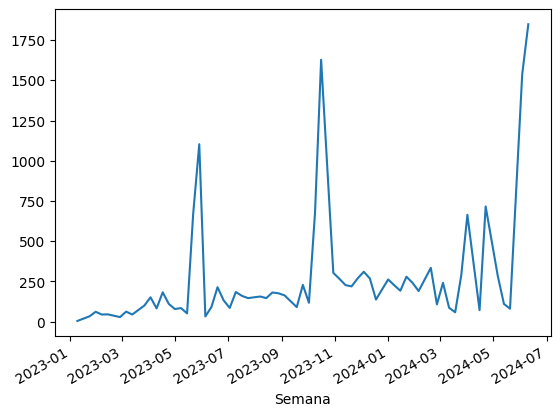

In [257]:
# Plot a time series for the ammount of rows per week

df['Semana'].value_counts().sort_index().plot()

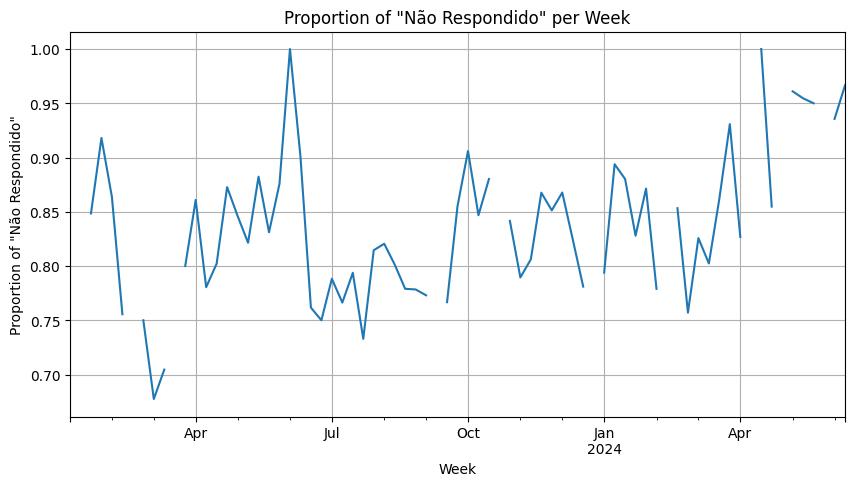

In [258]:
df['Não Respondido'] = df['STATUS'] == 'Não Respondeu'

# Group by week and calculate the proportion of "Não Respondido"
weekly_proportion = df.resample('W-Mon', on='Semana')['Não Respondido'].mean()

# Plotting
plt.figure(figsize=(10, 5))
weekly_proportion.plot( linestyle='-')
plt.title('Proportion of "Não Respondido" per Week')
plt.xlabel('Week')
plt.ylabel('Proportion of "Não Respondido"')
plt.grid(True)
plt.show()

In [259]:
# Count the frequency of the STATUS column

df['STATUS'].value_counts()


STATUS
Não Respondeu          15133
Reunião Marcada          912
Contato Respondido       496
Contato Encaminhado      433
Não se Interessou        413
Projeto                   34
Lead                      12
Reunião marcada            4
contato respondido         2
Contato encaminhado        2
Não se interessou          2
reunião realizada          1
                           1
Name: count, dtype: int64

In [260]:
#dropna of the first 6 columns

df = df.dropna(subset=df.columns[:6])

In [261]:
# Clean the values of Setor do Linkedin column

df['Setor do LinkedIn'] = df['Setor do LinkedIn'].str.lower().str.strip()

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/1406790230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Setor do LinkedIn'] = df['Setor do LinkedIn'].str.lower().str.strip()


In [262]:
def process_numero_de_funcionarios(value):
    try:
        # Replace different dashes with a standard dash
        value = re.sub(r'–|—', '-', value)
        # Handle ranges
        if '-' in value:
            min_val, max_val = map(int, re.split(r'\s*-\s*', value))
            return (min_val + max_val) / 2
        else:
            return int(value)
    except ValueError:
        # Handle invalid entries
        return None

# Apply the function to the 'Número de Funcionários' column
df['Número de Funcionários'] = df['Número de Funcionários'].apply(process_numero_de_funcionarios)

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/2024980564.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Número de Funcionários'] = df['Número de Funcionários'].apply(process_numero_de_funcionarios)


In [263]:
# Create a df with only the most frequent "Setor do LinkedIn" values

thresholds = [0, 50, 200, 500, 1000, 5000, 10000, float('inf')]
labels = ['1-50', '51-200', '201-500', '501-1000', '1001-5000', '5001-10000', '10001+']

status_encoding = {'Não Respondeu' : 0 , "Não se Interessou" :  0,  "Contato Respondido" : 1, "Contato Encaminhado" : 1,  "Reunião Marcada" : 2, "Lead": 3, "Projeto" : 3}

df['STATUS_encoded'] = df['STATUS'].map(status_encoding)

df.dropna(subset=['STATUS_encoded'], inplace=True)

df.dropna(subset=['Número de Funcionários', 'Empresa'], inplace=True)

idx = df.groupby('Empresa')['STATUS_encoded'].idxmax()


df_companies = df.loc[idx]

df_companies


/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/2450860264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STATUS_encoded'] = df['STATUS'].map(status_encoding)
/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/2450860264.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['STATUS_encoded'], inplace=True)
/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/2450860264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

,Semana,Empresa,Setor do LinkedIn,Número de Funcionários,Nome,Cargo,Email,Prospecção,STATUS,Hunter,Portfólio,Valor,ITIP,Não Respondido,STATUS_encoded
10867,2023-07-10,+A Educação,education,1200.0,Eduardo Abby,Diretor de Operações,eabby@maisaedu.com.br,E-mail,Reunião Marcada,catarina.sena,Analytics,NaN,NaN,False,2.0
1400,2023-03-27,3C Plus,computer software & internet,128.0,Ney Pereira,CEO,ney.pereira@3cplusnow.com,LinkedIn,Contato Encaminhado,pedro.avila,Analytics,NaN,NaN,False,1.0
4731,2023-04-03,3CORP,information technology & services,165.0,Marcos silva filho,CTO,NaN,LinkedIn,Não Respondeu,mateus.gurza,Analytics,NaN,NaN,True,0.0
16447,2023-10-16,3M Brazil,industrial,73000.0,Otavio Angele,Head of Business,NaN,LinkedIn,Reunião Marcada,maria.caira,Analytics,NaN,NaN,False,2.0
15484,2023-10-16,4BIO Medicamentos Especiais,health & fitness,370.0,Marcelo Wadt,Gerente de Analytics,mwadt@4bio.com.br,E-mail,Reunião Marcada,gabriel.moraes,Analytics,NaN,NaN,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15714,2023-10-16,Ãrvore,information technology & services,290.0,Anderson Konzen,Head,anderson@arvore.com.br,E-mail,Não Respondeu,alexandre.barsam,Analytics,NaN,NaN,True,0.0
28588,2024-03-18,Élis Energia,energy & environment,50.0,Caio Soares,Head,caio.soares@elisenergia.com.br,E-mail,Não Respondeu,arthur.daisuke,Analytics,NaN,NaN,True,0.0
9878,2023-06-19,Ília,computer software & internet,400.0,Isaac Canan,CTO,isaac.canan@ilia.digital,E-mail,Reunião Marcada,catarina.sena,Analytics,NaN,NaN,False,2.0
5444,2023-04-24,Órigo Energia,energy & environment,575.0,Alex Yamada,Head,alex.yamada@origoenergia.com.br,E-mail,Não Respondeu,mateus.gurza,Analytics,NaN,NaN,True,0.0


(1539, 2)
Total: 1539
education: 31
computer software & internet: 50
information technology & services: 284
industrial: 131
health & fitness: 83
energy & environment: 155
logistics & supply chain: 76
retail: 130
food & beverages: 114
consumer goods & services: 56
chemicals: 115
insurance: 58
marketing: 39
financial services: 177
outros: 40
education  Reunião Marcada: 18
education  Total%: 31
Percentualmente: 58.06%

computer software & internet  Reunião Marcada: 20
computer software & internet  Total%: 50
Percentualmente: 40.00%

information technology & services  Reunião Marcada: 120
information technology & services  Total%: 284
Percentualmente: 42.25%

industrial  Reunião Marcada: 72
industrial  Total%: 131
Percentualmente: 54.96%

health & fitness  Reunião Marcada: 34
health & fitness  Total%: 83
Percentualmente: 40.96%

energy & environment  Reunião Marcada: 50
energy & environment  Total%: 155
Percentualmente: 32.26%

logistics & supply chain  Reunião Marcada: 27
logistics & supp

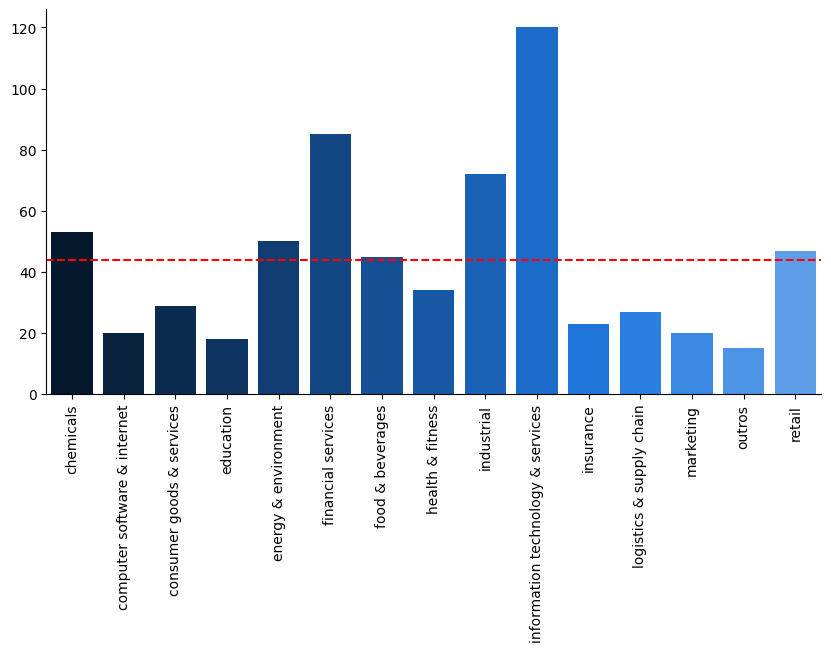

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


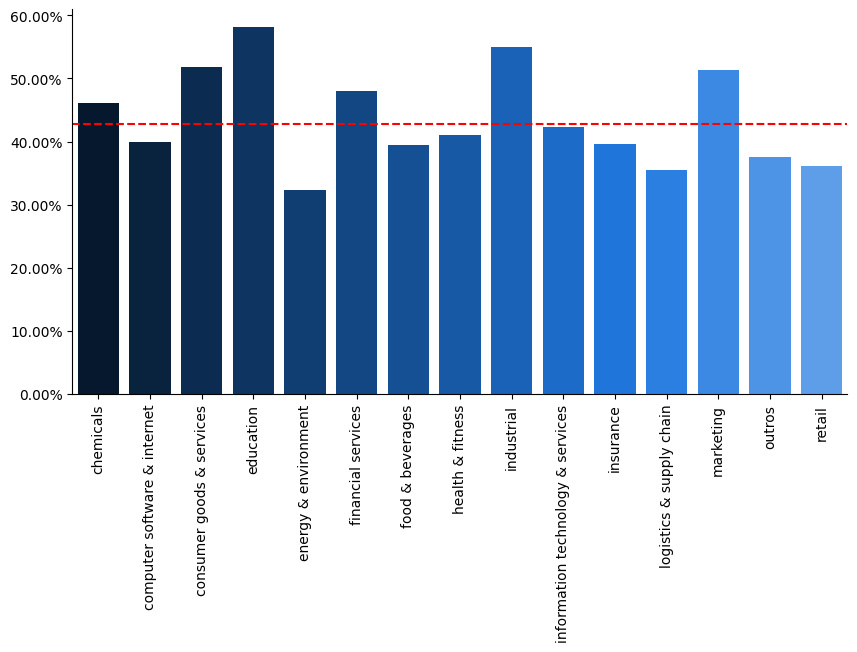

In [264]:
# Create a new column 'employee_category' based on the thresholds


df_companies['employee_category'] = pd.cut(df_companies['Número de Funcionários'], bins=thresholds, labels=labels, right=False)

df_companies.dropna(subset=['employee_category'], inplace=True)

dfmainsectors = df_companies[df_companies['Setor do LinkedIn'].isin(df_companies['Setor do LinkedIn'].value_counts().head(15).index)]

exploratory_report(dfmainsectors, 'STATUS', 'Reunião Marcada', 'Setor do LinkedIn')

(1539, 2)
Total: 1539
education: 31
computer software & internet: 50
information technology & services: 284
industrial: 131
health & fitness: 83
energy & environment: 155
logistics & supply chain: 76
retail: 130
food & beverages: 114
consumer goods & services: 56
chemicals: 115
insurance: 58
marketing: 39
financial services: 177
outros: 40
education  Projeto: 0
education  Total%: 31
Percentualmente: 0.00%

computer software & internet  Projeto: 0
computer software & internet  Total%: 50
Percentualmente: 0.00%

information technology & services  Projeto: 0
information technology & services  Total%: 284
Percentualmente: 0.00%

industrial  Projeto: 5
industrial  Total%: 131
Percentualmente: 3.82%

health & fitness  Projeto: 1
health & fitness  Total%: 83
Percentualmente: 1.20%

energy & environment  Projeto: 6
energy & environment  Total%: 155
Percentualmente: 3.87%

logistics & supply chain  Projeto: 4
logistics & supply chain  Total%: 76
Percentualmente: 5.26%

retail  Projeto: 2
retail

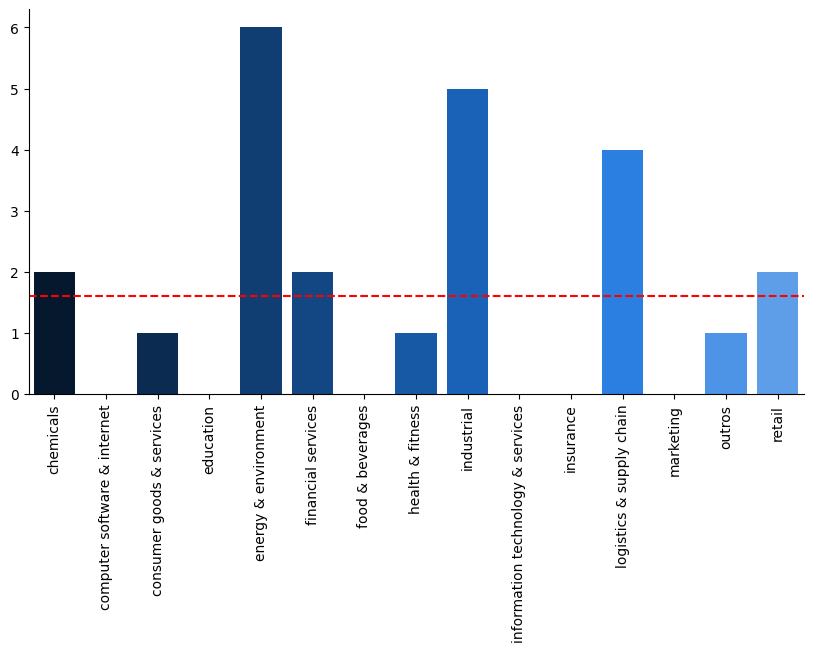

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


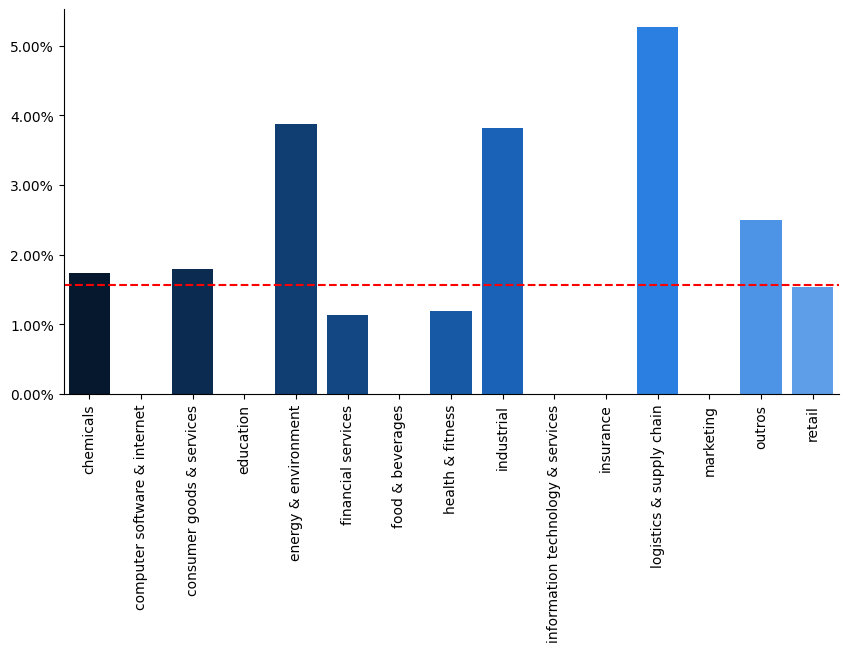

In [265]:
exploratory_report(dfmainsectors, 'STATUS', 'Projeto', 'Setor do LinkedIn')

In [266]:
# Count the frequency of "Cargo" column

df['Cargo'].value_counts()

Cargo
Diretor                         4434
Head                            1913
Outros                          1116
Gerente                         1096
CEO                             1031
                                ... 
Director                           1
Head Of Corporate Finance          1
CFO, IR and ESG Director           1
Head of Sourcing                   1
Superintendente de Analytics       1
Name: count, Length: 191, dtype: int64

In [267]:
import pandas as pd
from rapidfuzz import process

# Define the number of most common values to consider
num_common = 10  # Adjust this number as needed
similarity_threshold = 80  # Adjust this threshold as needed

# Get the most common values in 'Cargo'
common_cargos = df['Cargo'].value_counts().index[:num_common]

# Function to apply fuzzy matching with a threshold
def fuzzy_match(cargo, choices, threshold):
    match = process.extractOne(cargo, choices, score_cutoff=threshold)
    if match:
        return match[0]  # match[0] contains the best match string
    else:
        return "others"

# Apply fuzzy matching using the most common values and classify as "others" if no close match
df['Cargo'] = df['Cargo'].apply(lambda x: fuzzy_match(x, common_cargos, similarity_threshold))

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/1619003796.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cargo'] = df['Cargo'].apply(lambda x: fuzzy_match(x, common_cargos, similarity_threshold))


(16840, 2)
Total: 16840
others: 1099
CTO: 587
CEO: 1037
Head: 3056
Diretor Comercial: 685
Diretor: 5576
Outros: 1435
Gerente: 1425
Diretor de Operações: 551
CFO: 592
Presidente/Vice Presidente: 797
others  Reunião Marcada: 61
others  Total%: 1099
Percentualmente: 5.55%

CTO  Reunião Marcada: 25
CTO  Total%: 587
Percentualmente: 4.26%

CEO  Reunião Marcada: 23
CEO  Total%: 1037
Percentualmente: 2.22%

Head  Reunião Marcada: 182
Head  Total%: 3056
Percentualmente: 5.96%

Diretor Comercial  Reunião Marcada: 21
Diretor Comercial  Total%: 685
Percentualmente: 3.07%

Diretor  Reunião Marcada: 232
Diretor  Total%: 5576
Percentualmente: 4.16%

Outros  Reunião Marcada: 125
Outros  Total%: 1435
Percentualmente: 8.71%

Gerente  Reunião Marcada: 112
Gerente  Total%: 1425
Percentualmente: 7.86%

Diretor de Operações  Reunião Marcada: 26
Diretor de Operações  Total%: 551
Percentualmente: 4.72%

CFO  Reunião Marcada: 27
CFO  Total%: 592
Percentualmente: 4.56%

Presidente/Vice Presidente  Reunião Marc

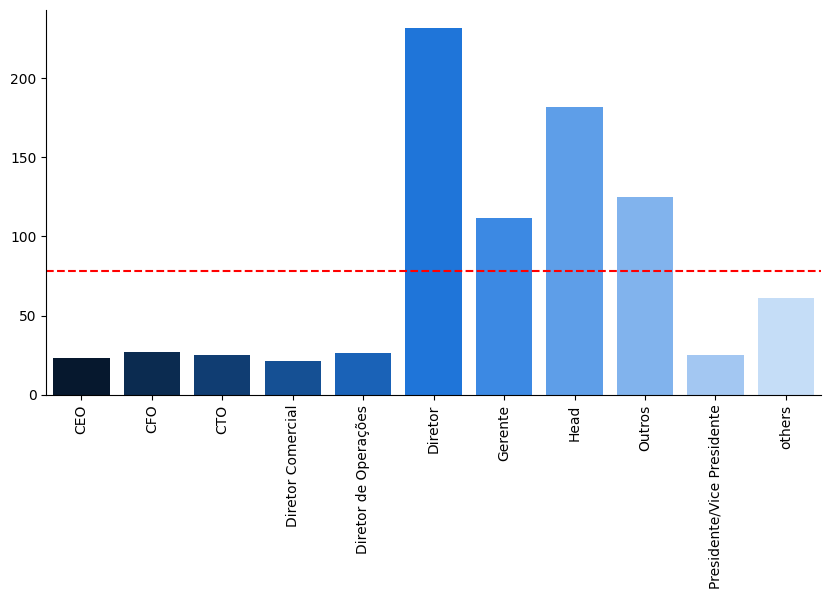

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


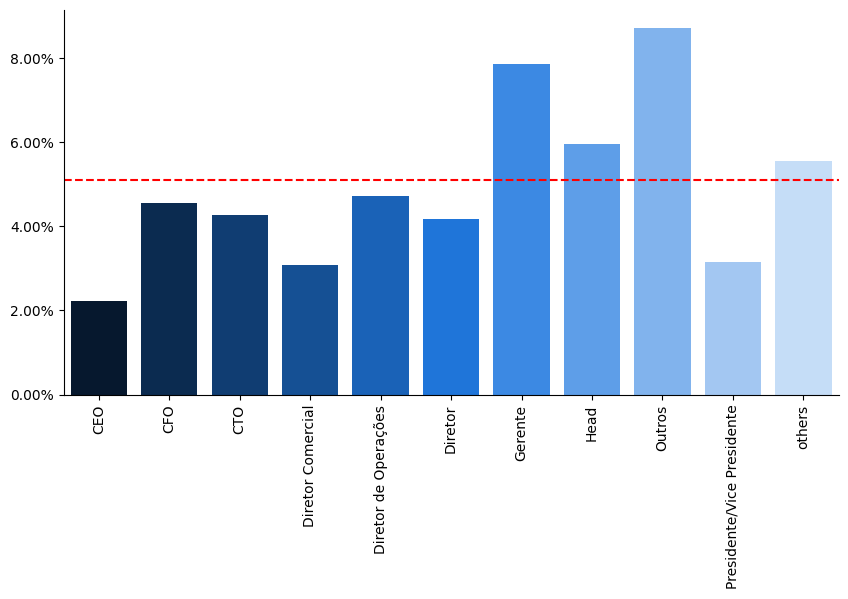

In [268]:
# Create a df with only the most frequent "Cargo" values

dfmaincargo = df[df['Cargo'].isin(df['Cargo'].value_counts().head(15).index)]

exploratory_report(dfmaincargo, 'STATUS', 'Reunião Marcada', 'Cargo')

(16840, 2)
Total: 16840
others: 1099
CTO: 587
CEO: 1037
Head: 3056
Diretor Comercial: 685
Diretor: 5576
Outros: 1435
Gerente: 1425
Diretor de Operações: 551
CFO: 592
Presidente/Vice Presidente: 797
others  Projeto: 0
others  Total%: 1099
Percentualmente: 0.00%

CTO  Projeto: 0
CTO  Total%: 587
Percentualmente: 0.00%

CEO  Projeto: 1
CEO  Total%: 1037
Percentualmente: 0.10%

Head  Projeto: 3
Head  Total%: 3056
Percentualmente: 0.10%

Diretor Comercial  Projeto: 0
Diretor Comercial  Total%: 685
Percentualmente: 0.00%

Diretor  Projeto: 9
Diretor  Total%: 5576
Percentualmente: 0.16%

Outros  Projeto: 8
Outros  Total%: 1435
Percentualmente: 0.56%

Gerente  Projeto: 3
Gerente  Total%: 1425
Percentualmente: 0.21%

Diretor de Operações  Projeto: 1
Diretor de Operações  Total%: 551
Percentualmente: 0.18%

CFO  Projeto: 0
CFO  Total%: 592
Percentualmente: 0.00%

Presidente/Vice Presidente  Projeto: 2
Presidente/Vice Presidente  Total%: 797
Percentualmente: 0.25%



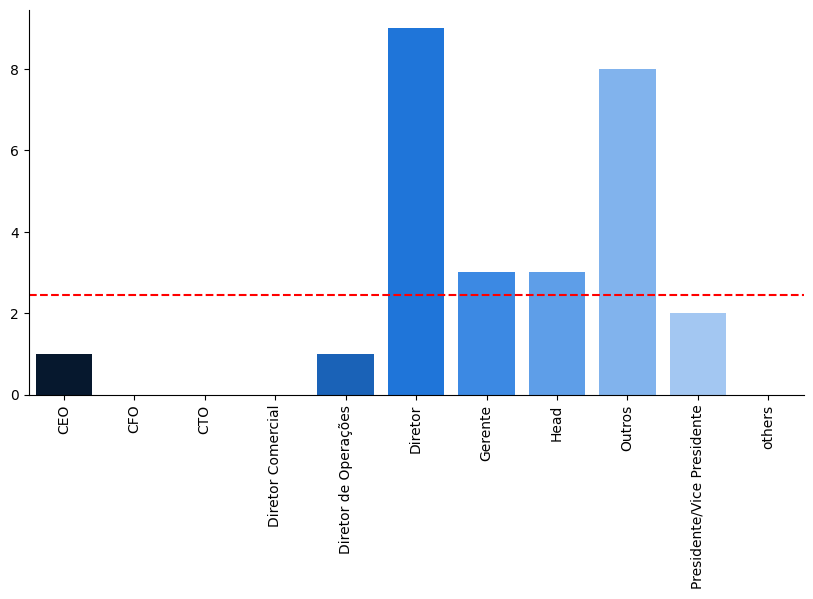

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


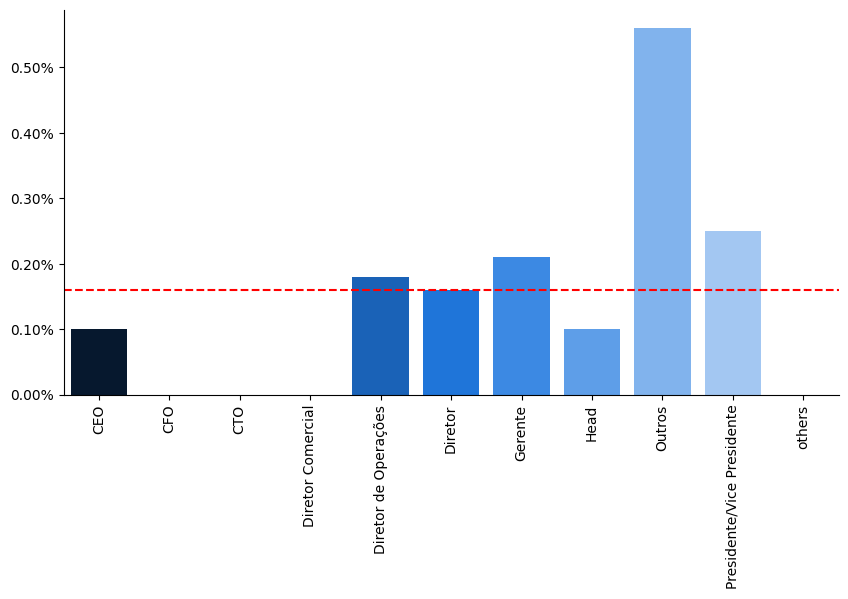

In [269]:
exploratory_report(dfmaincargo, 'STATUS', 'Projeto', 'Cargo')

(16840, 2)
Total: 16840
E-mail: 15282
LinkedIn: 1558
E-mail  Reunião Marcada: 640
E-mail  Total%: 15282
Percentualmente: 4.19%

LinkedIn  Reunião Marcada: 219
LinkedIn  Total%: 1558
Percentualmente: 14.06%



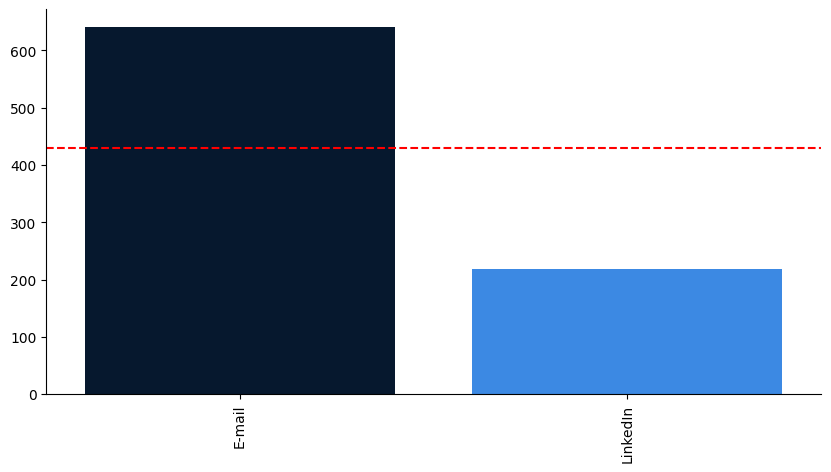

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


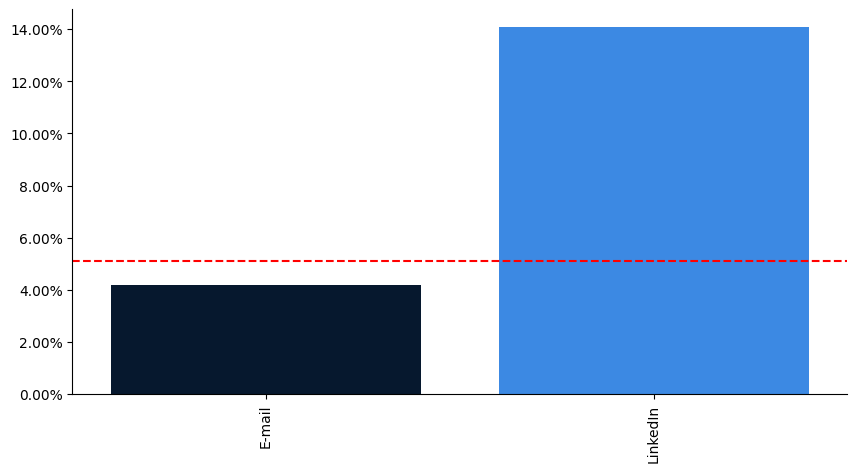

In [270]:
exploratory_report(df, 'STATUS', 'Reunião Marcada', 'Prospecção')

(16840, 2)
Total: 16840
E-mail: 15282
LinkedIn: 1558
E-mail  Projeto: 24
E-mail  Total%: 15282
Percentualmente: 0.16%

LinkedIn  Projeto: 3
LinkedIn  Total%: 1558
Percentualmente: 0.19%



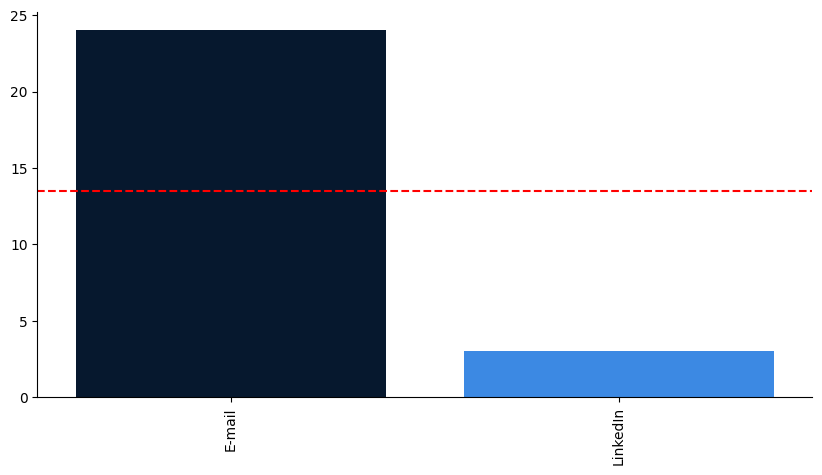

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


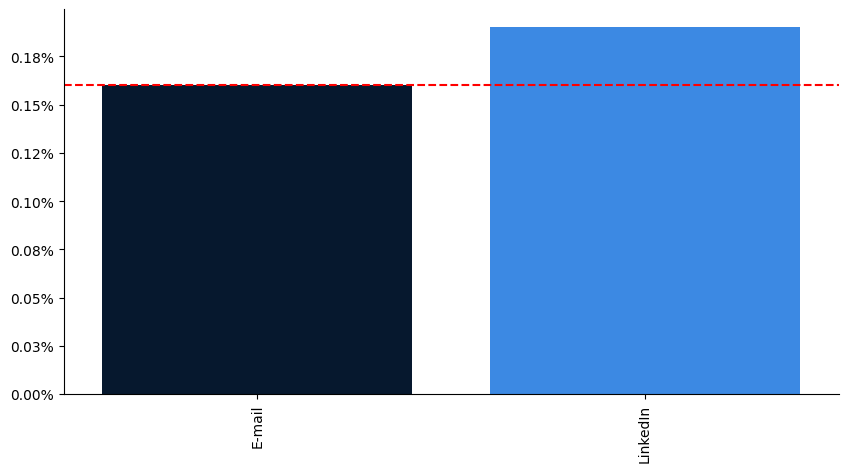

In [271]:
exploratory_report(df, 'STATUS', 'Projeto', 'Prospecção')

(1694, 2)
Total: 1694
1001-5000: 378
51-200: 352
10001+: 186
201-500: 370
501-1000: 252
5001-10000: 85
1-50: 71
1001-5000  Reunião Marcada: 174
1001-5000  Total%: 378
Percentualmente: 46.03%

51-200  Reunião Marcada: 140
51-200  Total%: 352
Percentualmente: 39.77%

10001+  Reunião Marcada: 102
10001+  Total%: 186
Percentualmente: 54.84%

201-500  Reunião Marcada: 153
201-500  Total%: 370
Percentualmente: 41.35%

501-1000  Reunião Marcada: 110
501-1000  Total%: 252
Percentualmente: 43.65%

5001-10000  Reunião Marcada: 35
5001-10000  Total%: 85
Percentualmente: 41.18%

1-50  Reunião Marcada: 15
1-50  Total%: 71
Percentualmente: 21.13%



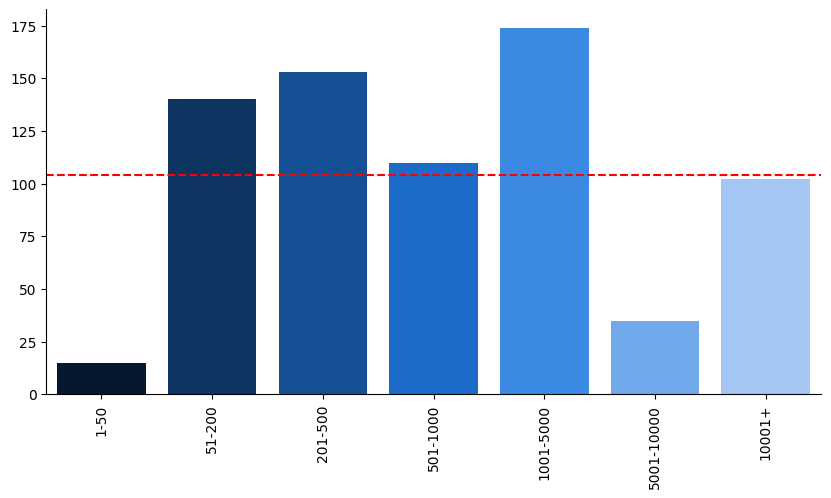

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/815668103.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


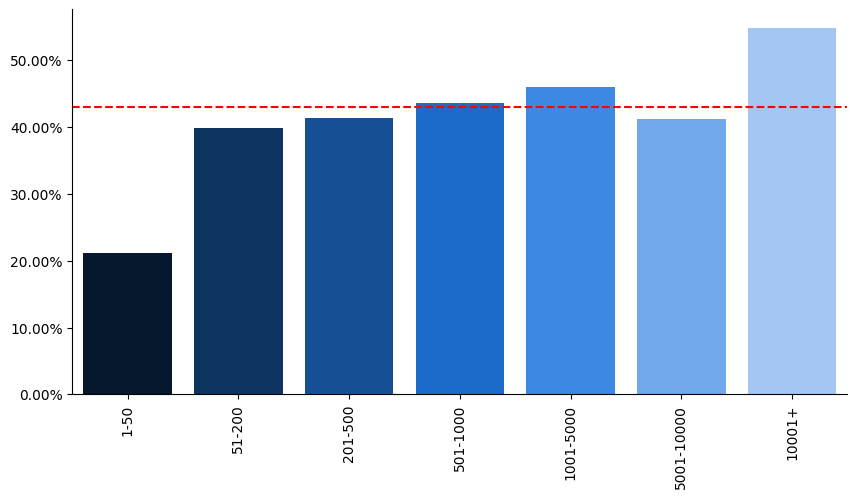

In [272]:
exploratory_report(df_companies, 'STATUS', 'Reunião Marcada', 'employee_category')

(1694, 2)
Total: 1694
1001-5000: 378
51-200: 352
10001+: 186
201-500: 370
501-1000: 252
5001-10000: 85
1-50: 71
1001-5000  Projeto: 6
1001-5000  Total%: 378
Percentualmente: 1.59%

51-200  Projeto: 6
51-200  Total%: 352
Percentualmente: 1.70%

10001+  Projeto: 4
10001+  Total%: 186
Percentualmente: 2.15%

201-500  Projeto: 5
201-500  Total%: 370
Percentualmente: 1.35%

501-1000  Projeto: 4
501-1000  Total%: 252
Percentualmente: 1.59%

5001-10000  Projeto: 1
5001-10000  Total%: 85
Percentualmente: 1.18%

1-50  Projeto: 0
1-50  Total%: 71
Percentualmente: 0.00%



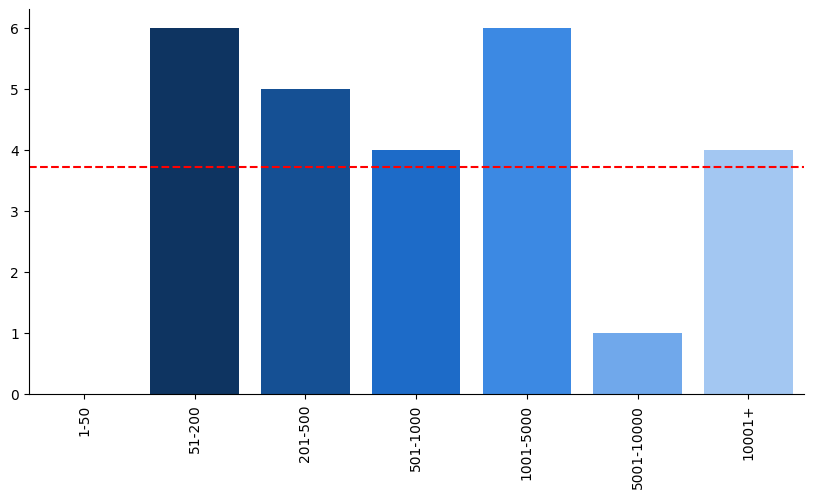

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_1816/815668103.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


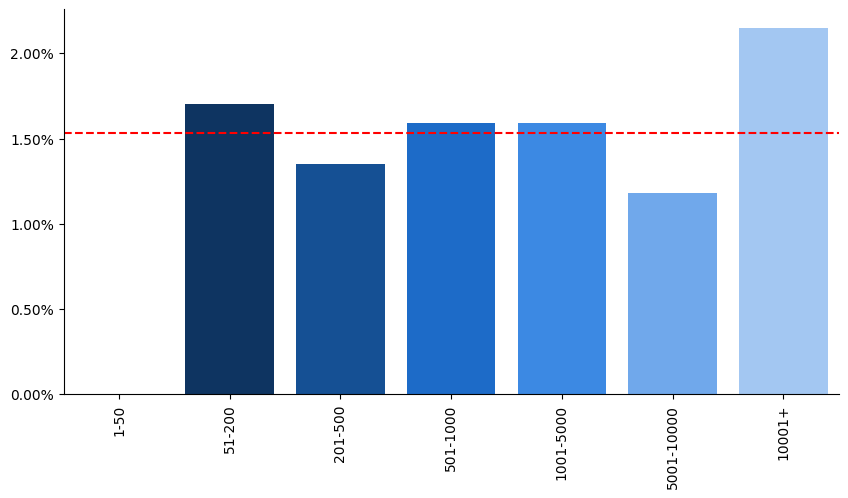

In [273]:
exploratory_report(df_companies, 'STATUS', 'Projeto', 'employee_category')